# Assessing Model Results

This notebook serves as an initial assessment of mixing and stratification in SLO Bay. Eddy viscosity is used to quantify mixing while temperature is used to visualize stratification. 

This notebook is divided into two main parts:

### 1. Averaged time series for the total analysed grid area
   * Mean eddy viscosity and temperature for the surface
   * Mean eddy viscosity and temperature for a transect

### 2. Movie creation
   * Eddy viscosity and temperature for the surface
   * Eddy viscosity and temperature for a transect
     
First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip
from moviepy.editor import ImageSequenceClip

Then, re-create the model grid

In [3]:
diags_dir_kpp = '../data_kpp/'
diags_dir_tke = '../data_tke/'


delX = 1/480
delY = 1/480
xgOrigin = -120.9  
ygOrigin =  34.9 
n_rows = 180 
n_cols = 180 
n_depths = 100
tke_vars=7 
kpp_vars=5

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

### Mask wet cells

In [6]:
hfacC = np.fromfile('hFacC.data', dtype='>f4').reshape((n_depths, n_rows, n_cols))
surface_mask = hfacC[0, :, :] > 0
transect_mask = surface_mask[90, :]

### Create timeseries for the surface

In [19]:
tke_GGL90ArU_timeseries = []
tke_theta_timeseries = []
kpp_viscA_timeseries = []
kpp_theta_timeseries = []
valid_days = []

days = list(range(1800000, 2299680, 360))

for day in days:

    # identify the data file path
    kpp_data_path = os.path.join(diags_dir_kpp, f'hourly_means.{day:010d}.data') 
    
           
    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_kpp_size = kpp_vars * n_rows * n_cols * n_depths
    kpp_data = np.fromfile(kpp_data_path, dtype='>f4')
    if kpp_data.size != expected_kpp_size:
        print('wrong file size :(')
        continue

    #reshape grid and define variables
    kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))
    KPPviscA_surface = kpp_grid[0, 1, :, :]
    theta_kpp_surface = kpp_grid[1, 1, :, :]

    #mask variables and find mean
    KPPviscA_masked = np.ma.masked_where(surface_mask == 0, KPPviscA_surface)
    mean_KPPviscA = KPPviscA_masked.mean()
    KPPtheta_masked = np.ma.masked_where(surface_mask == 0, theta_kpp_surface)
    mean_KPPtheta = KPPtheta_masked.mean()
    
    # identify the data file path
    tke_data_path = os.path.join(diags_dir_tke, f'hourly_means.{day:010d}.data')

        
    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_tke_size = tke_vars * n_rows * n_cols * n_depths
    tke_data = np.fromfile(tke_data_path, dtype='>f4')
    if tke_data.size % expected_tke_size != 0:
        print(' file is the wrong size :(')
        continue

    #reshape grid and define variables
    tke_grid = tke_data.reshape((tke_vars, n_depths, n_rows, n_cols))
    GGL90ArU_surface = tke_grid[6, 1, :, :]
    theta_tke_surface = tke_grid[0, 1,:, :]

    #mask variables and find mean
    TKEmasked = np.ma.masked_where(surface_mask == 0, GGL90ArU_surface)
    mean_GGL90ArU = TKEmasked.mean()
    TKEtheta_masked = np.ma.masked_where(surface_mask == 0, theta_tke_surface)
    mean_TKEtheta = TKEtheta_masked.mean()


    tke_GGL90ArU_timeseries.append(mean_GGL90ArU)
    tke_theta_timeseries.append(mean_TKEtheta)
    kpp_viscA_timeseries.append(mean_KPPviscA)
    kpp_theta_timeseries.append(mean_KPPtheta)
    valid_days.append(day)

# create labels forx axis
days_array = np.array(valid_days)
actual_days = days_array / 86400
whole_days = actual_days[actual_days % 1 == 0]

 file is the wrong size :(


## Plot a model fields at one timestep with time series 

I'll choose an arbitrary date of Jan 25th to demonstrate the differences between temperature for KPP and TKE mixing schemes at the surface. After reading in the fields. I'll then plot it alongside mean temperature timeseries for approximatley the last week of January. 

The same steps will be done for eddy viscosity.

In [22]:

# File paths for January 25 for GGL90 and KPP
Jan_25_tke = '../data_tke/hourly_means.0002161800.data'
Jan_25_kpp = '../data_kpp/hourly_means.0002161800.data'

# Reading in data for GGL90
tke_data = np.fromfile(Jan_25_tke, dtype='>f4')
tke_grid = tke_data.reshape((tke_vars, n_depths, n_rows, n_cols))

GGL90ArU_surface = tke_grid[6, 1, :, :]
GGL90_theta_surface = tke_grid[0, 1, :, :]

# Mask
TKE_GGL90ArU_masked = np.ma.masked_where(surface_mask == 0, GGL90ArU_surface)
TKE_theta_masked = np.ma.masked_where(surface_mask == 0, GGL90_theta_surface)

# Reading in data for KPP
kpp_data = np.fromfile(Jan_25_kpp, dtype='>f4')
kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))

KPPviscA_surface = kpp_grid[0, 1, :, :]
KPPtheta_surface = kpp_grid[1, 1, :, :]

# Mask
KPP_viscA_masked = np.ma.masked_where(surface_mask == 0, KPPviscA_surface)
KPP_theta_masked = np.ma.masked_where(surface_mask == 0, KPPtheta_surface)

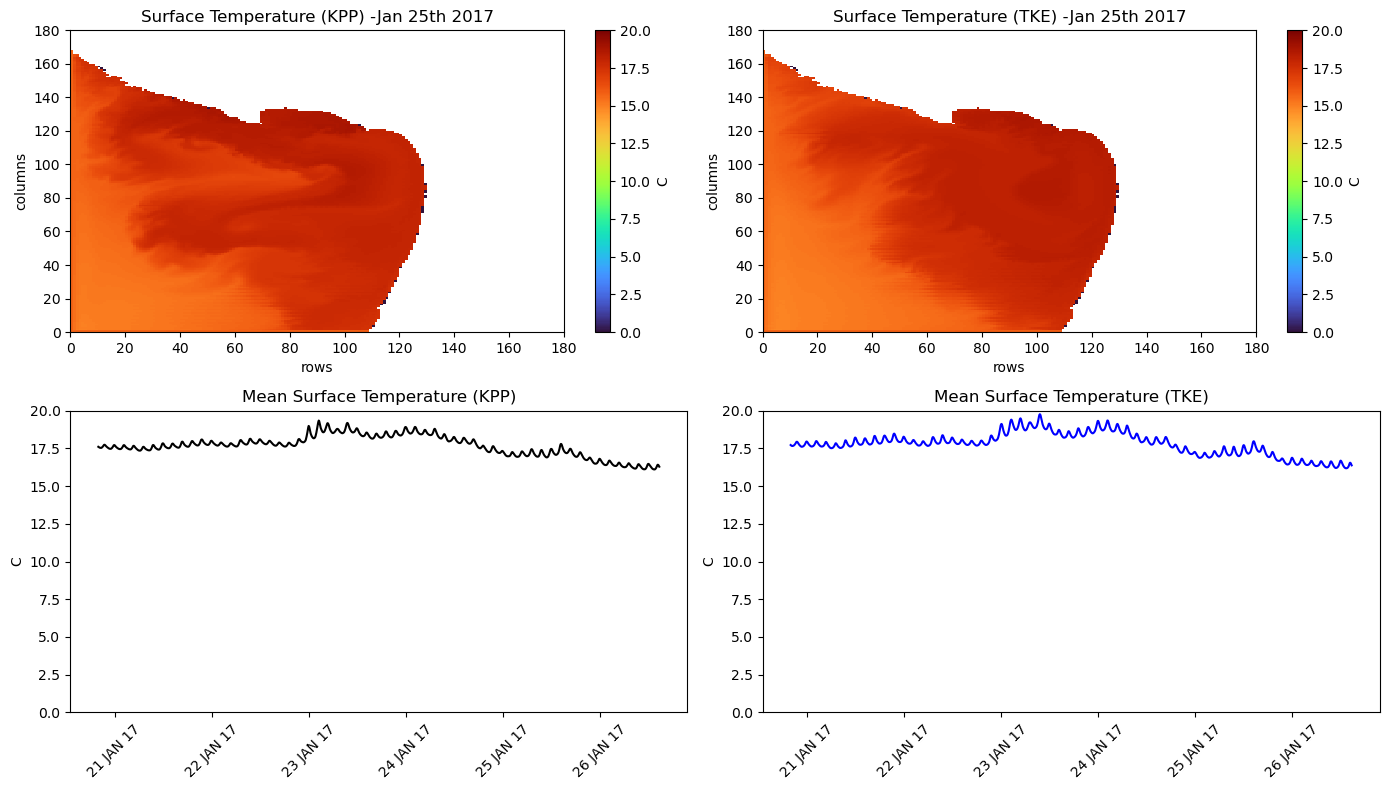

In [24]:
#Plots
# Plotting temperature surface visualization 
fig = plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
C = plt.pcolormesh(KPP_theta_masked, cmap='turbo', vmin=0, vmax=20)
plt.title('Surface Temperature (KPP) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'C')


plt.subplot(2,2,2)
C = plt.pcolormesh(TKE_theta_masked, cmap='turbo', vmin=0, vmax=20)
plt.title('Surface Temperature (TKE) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'C')

# Plotting the temperature timeseries
plt.subplot(2, 2, 3)
plt.title('Mean Surface Temperature (KPP)')
plt.plot(actual_days, kpp_theta_timeseries, 'k-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('C')
plt.ylim(0, 20)

plt.subplot(2, 2, 4)
plt.title('Mean Surface Temperature (TKE)')
plt.plot(actual_days, tke_theta_timeseries, 'b-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('C')
plt.ylim(0, 20)

plt.tight_layout()
plt.show()

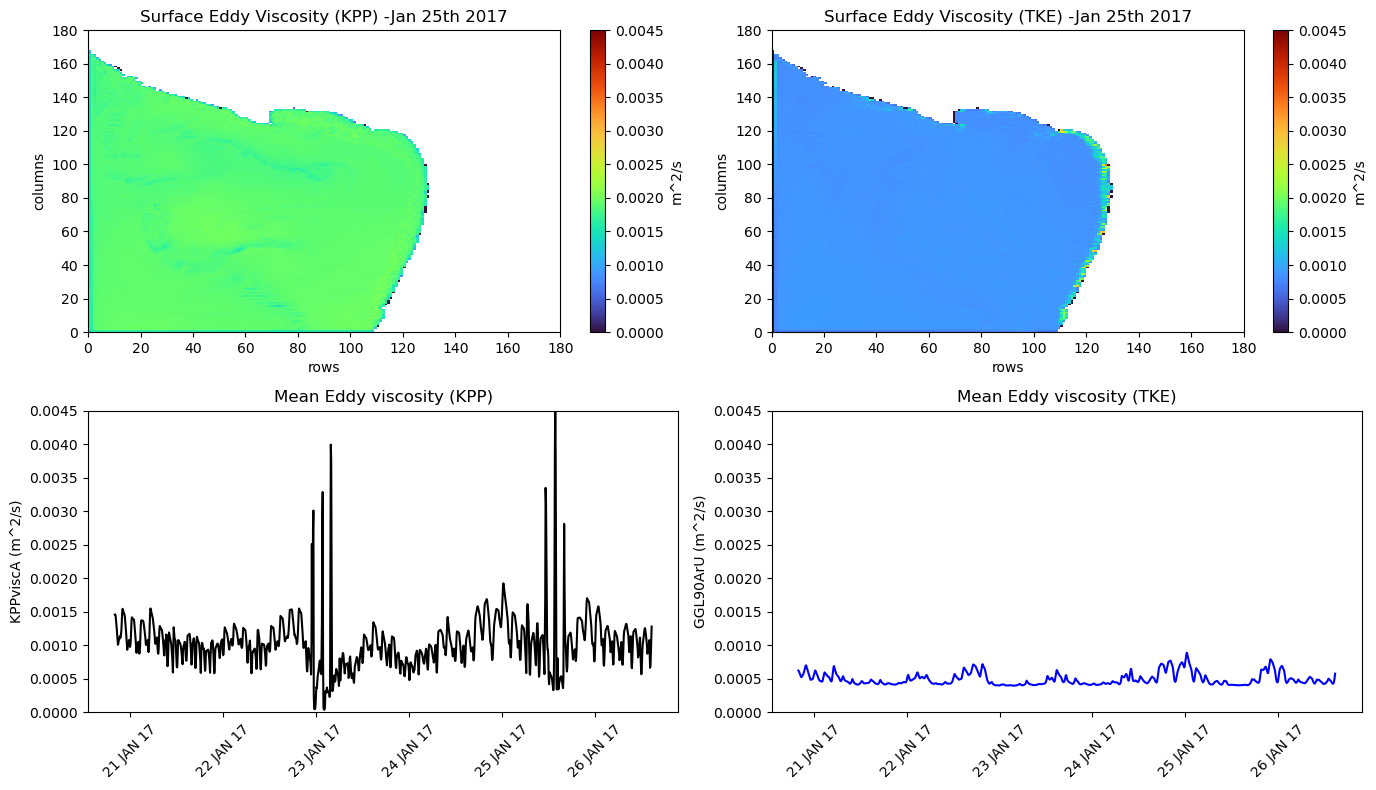

In [26]:
#Plots

fig = plt.figure(figsize=(14,8))

# Plotting eddy viscosity surface visualization
plt.subplot(2,2,1)
C = plt.pcolormesh(KPP_viscA_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.title('Surface Eddy Viscosity (KPP) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'm^2/s')


plt.subplot(2,2,2)
C = plt.pcolormesh(TKE_GGL90ArU_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.title('Surface Eddy Viscosity (TKE) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'm^2/s')

# Plotting the eddy viscosity timeseries
plt.subplot(2, 2, 3)
plt.title('Mean Eddy viscosity (KPP)')
plt.plot(actual_days, kpp_viscA_timeseries, 'k-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('KPPviscA (m^2/s)')
plt.ylim(0, 0.0045)

plt.subplot(2, 2, 4)
plt.title('Mean Eddy viscosity (TKE)')
plt.plot(actual_days, tke_GGL90ArU_timeseries, 'b-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('GGL90ArU (m^2/s)')
plt.ylim(0, 0.0045)

plt.tight_layout()
plt.show()

### Create timeseries for a transect

In [28]:
tke_GGL90ArU_transect_timeseries = []
tke_theta_transect_timeseries = []
kpp_viscA_transect_timeseries = []
kpp_theta_transect_timeseries = []
valid_days = []

days = list(range(1800000, 2299680, 360))

for day in days:

    # identify the data file path
    kpp_data_path = os.path.join(diags_dir_kpp, f'hourly_means.{day:010d}.data')

    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_kpp_size = kpp_vars * n_rows * n_cols * n_depths
    kpp_data = np.fromfile(kpp_data_path, dtype='>f4')
    
    if kpp_data.size != expected_kpp_size:
        print('wrong file size :(')
        continue

    #reshape grid and define variables
    kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))
    KPPviscA_transect = kpp_grid[0, :, 90, :]
    theta_kpp_transect = kpp_grid[1, :, 90, :]

    #mask
    transect_mask_2d = np.broadcast_to(transect_mask == 0, KPPviscA_transect.shape)
    KPPviscA_masked = np.ma.masked_array(KPPviscA_transect, mask=transect_mask_2d)
    KPPtheta_masked = np.ma.masked_array(theta_kpp_transect, mask=transect_mask_2d)

    #find mean
    mean_KPPviscA = KPPviscA_masked.mean()
    mean_KPPtheta = KPPtheta_masked.mean()
    
    # identify the data file path
    tke_data_path = os.path.join(diags_dir_tke, f'hourly_means.{day:010d}.data')

    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_tke_size = tke_vars * n_rows * n_cols * n_depths
    tke_data = np.fromfile(tke_data_path, dtype='>f4')
    
    if tke_data.size % expected_tke_size != 0:
        print(' file is the wrong size :(')
        continue
        
    #reshape grid and define variables
    tke_grid = tke_data.reshape((tke_vars, n_depths, n_rows, n_cols))
    GGL90ArU_transect = tke_grid[6, :, 90, :]
    theta_tke_transect = tke_grid[0, :, 90, :]

    #mask
    TKEmasked = np.ma.masked_array(GGL90ArU_transect, mask=transect_mask_2d)
    TKEtheta_masked = np.ma.masked_array(theta_tke_transect, mask=transect_mask_2d)
    #find mean
    mean_GGL90ArU = TKEmasked.mean()
    mean_TKEtheta = TKEtheta_masked.mean()


    tke_GGL90ArU_transect_timeseries.append(mean_GGL90ArU)
    tke_theta_transect_timeseries.append(mean_TKEtheta)
    kpp_viscA_transect_timeseries.append(mean_KPPviscA)
    kpp_theta_transect_timeseries.append(mean_KPPtheta)
    valid_days.append(day)

# create labels forx axis
days_array = np.array(valid_days)
actual_days = days_array / 86400
whole_days = actual_days[actual_days % 1 == 0]

 file is the wrong size :(


## Plot a model fields at one timestep with time series 

I'll choose an arbitrary date of Jan 25th to demonstrate the differences between temperature for KPP and TKE mixing schemes along a transect. After reading in the fields. I'll then plot it alongside mean temperature timeseries for approximatley the last week of January. 

The same steps will be done for eddy viscosity.

In [33]:

GGL90ArU_transect = tke_grid[6, :, 90, :]
GGL90_theta_transect = tke_grid[0, :, 90, :]

# Mask
transect_mask_2d = np.broadcast_to(transect_mask == 0, GGL90ArU_transect.shape)
TKE_GGL90ArU_transect_masked = np.ma.masked_array(GGL90ArU_transect, mask=transect_mask_2d)
TKE_theta_transect_masked = np.ma.masked_array(GGL90_theta_transect, mask=transect_mask_2d)

# Reading in data for eddy viscosity, temperature, and salinity for KPP model
kpp_data = np.fromfile(Jan_25_kpp, dtype='>f4')
kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))

KPPviscA_transect = kpp_grid[0, :, 90, :]
KPPtheta_transect = kpp_grid[1, :, 90, :]

# Mask
KPP_viscA_transect_masked = np.ma.masked_array(KPPviscA_transect, mask=transect_mask_2d)
KPP_theta_transect_masked = np.ma.masked_array(KPPtheta_transect, mask=transect_mask_2d)

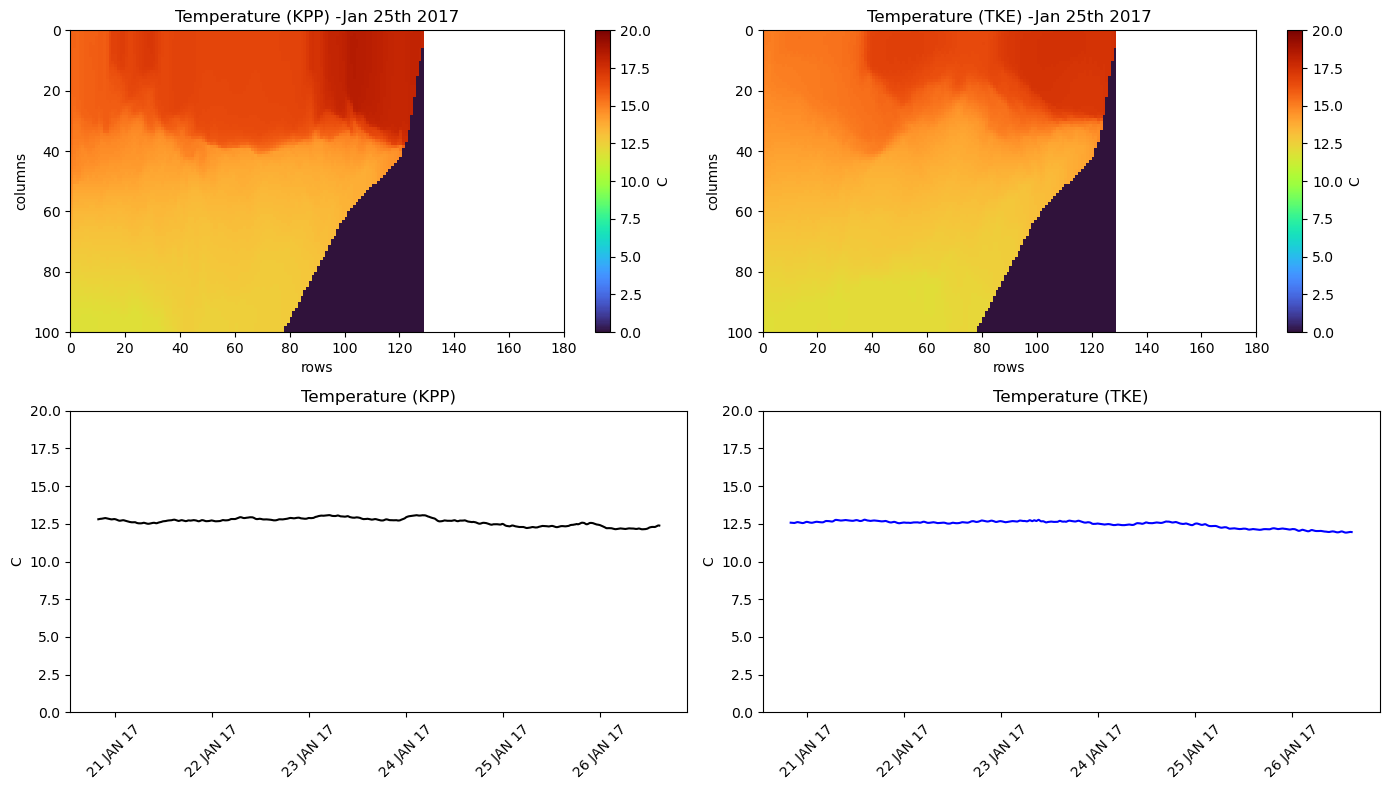

In [35]:
#Plots

#temperature visualization along a transect
fig = plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
C = plt.pcolormesh(KPP_theta_transect_masked, cmap='turbo', vmin=0, vmax=20)
plt.title('Temperature (KPP) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.gca().invert_yaxis()
plt.colorbar(C, label = 'C')


plt.subplot(2,2,2)
C = plt.pcolormesh(TKE_theta_transect_masked, cmap='turbo', vmin=0, vmax=20)
plt.title('Temperature (TKE) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.gca().invert_yaxis()
plt.colorbar(C, label = 'C')

# mean temperature timeseries for a transect
plt.subplot(2, 2, 3)
plt.title('Temperature (KPP)')
plt.plot(actual_days, kpp_theta_transect_timeseries, 'k-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('C')
plt.gca().invert_yaxis()
plt.ylim(0, 20)

plt.subplot(2, 2, 4)
plt.title('Temperature (TKE)')
plt.plot(actual_days, tke_theta_transect_timeseries, 'b-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('C')
plt.gca().invert_yaxis()
plt.ylim(0, 20)

plt.tight_layout()
plt.show()

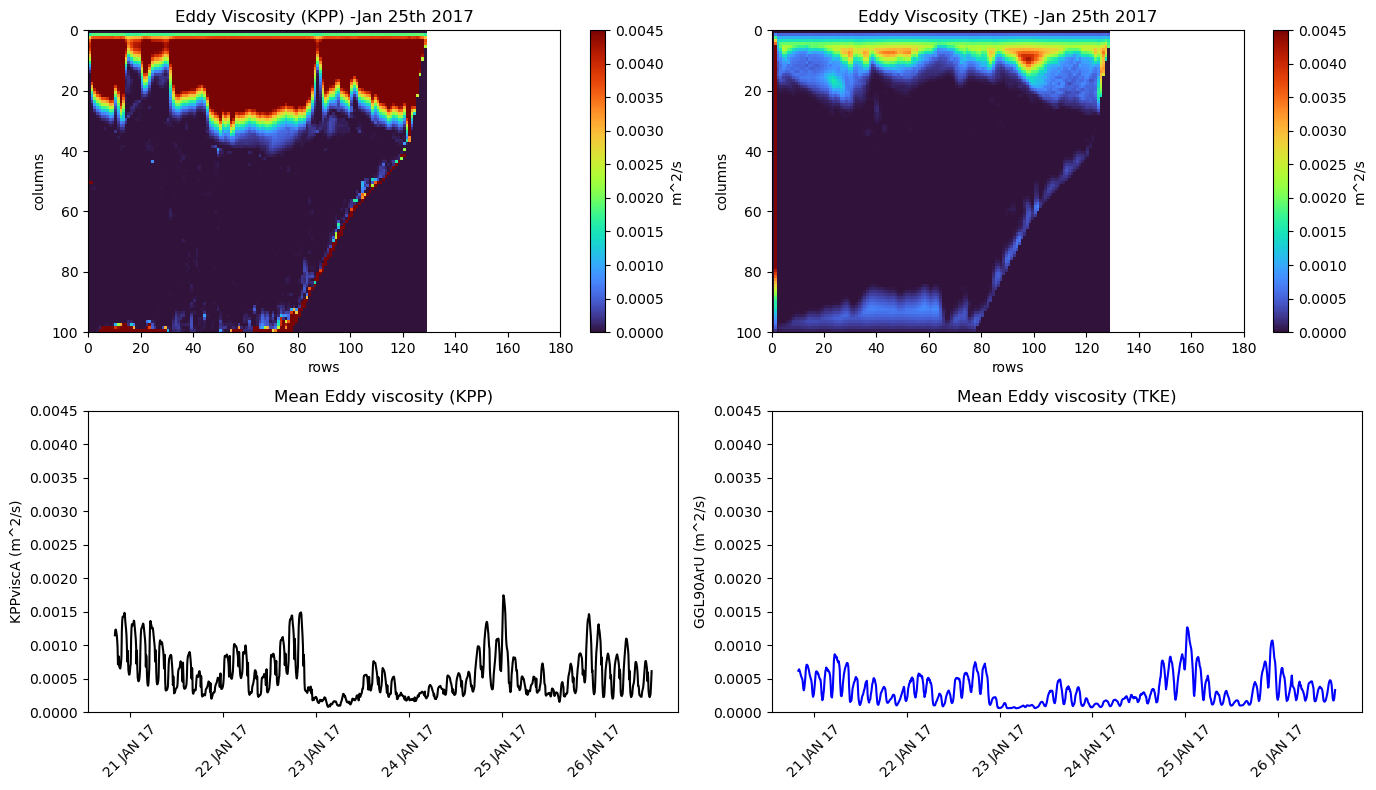

In [37]:
#Plots

#Eddy viscosity visualiztion along atransect
fig = plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
C = plt.pcolormesh(KPP_viscA_transect_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.title('Eddy Viscosity (KPP) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.gca().invert_yaxis()
plt.colorbar(C, label = 'm^2/s')


plt.subplot(2,2,2)
C = plt.pcolormesh(TKE_GGL90ArU_transect_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.title('Eddy Viscosity (TKE) -Jan 25th 2017')
plt.xlabel('rows')
plt.ylabel('columns')
plt.gca().invert_yaxis()
plt.colorbar(C, label = 'm^2/s')

# mean eddy viscosity timeseries for a transect
plt.subplot(2, 2, 3)
plt.title('Mean Eddy viscosity (KPP)')
plt.plot(actual_days, kpp_viscA_transect_timeseries, 'k-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('KPPviscA (m^2/s)')
plt.gca().invert_yaxis()
plt.ylim(0, 0.0045)

plt.subplot(2, 2, 4)
plt.title('Mean Eddy viscosity (TKE)')
plt.plot(actual_days, tke_GGL90ArU_transect_timeseries, 'b-')
plt.xticks(whole_days, [str(int(d)) + ' JAN 17' for d in whole_days], rotation=45)
plt.ylabel('GGL90ArU (m^2/s)')
plt.gca().invert_yaxis()
plt.ylim(0, 0.0045)

plt.tight_layout()
plt.show()

### Movies
Now we'll create movies for temperature and eddy viscosity. The first function will be a movie along a transect and the second will be of the surface.

In [56]:
def generate_transect_frames(tke_path, kpp_path, image_path, var_name='visc', row_index=90, vmin=None, vmax=None):

    # Load TKE
    if not os.path.exists(tke_path):
        print('file not here')
        return False
    expected_tke_size = tke_vars * n_rows * n_cols * n_depths
    tke_data = np.fromfile(tke_path, dtype='>f4')
    if tke_data.size != expected_tke_size:
        print('wrong file size :(')
        return False
    tke_grid = tke_data.reshape(tke_vars, n_depths, n_rows, n_cols)
    
    # Load KPP
    if not os.path.exists(kpp_path):
        print('file not here')
        return False
    expected_kpp_size = kpp_vars * n_rows * n_cols * n_depths
    kpp_data = np.fromfile(kpp_path, dtype='>f4')
    if kpp_data.size != expected_kpp_size:
        print('wrong file size :(')
        return False
        
    kpp_grid = kpp_data.reshape(kpp_vars, n_depths, n_rows, n_cols)
    
    # Map variable name to index
    if var_name == 'visc':
        tke_idx = 6
        kpp_idx = 0
        label = 'm^2/s'
        title = 'Eddy Viscosity'
    elif var_name == 'theta':
        tke_idx = 0
        kpp_idx = 1
        label = 'C'
        title = 'Temperature'
    
    
    tke_slice = tke_grid[tke_idx, :, row_index, :] 
    kpp_slice = kpp_grid[kpp_idx, :, row_index, :] 
    
 
    fig = plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.pcolormesh(tke_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    plt.gca().invert_yaxis()
    
    # add a colorbar
    plt.colorbar(label = label)
                   
    # format the axes
    plt.ylabel('Model Rows')
    plt.xlabel('Model Cols')
    plt.title(f'{title} (TKE)')
  
    
    plt.subplot(1,2,2)
    # plot the field
    plt.pcolormesh(kpp_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    plt.gca().invert_yaxis()
    
    # add a colorbar
    plt.colorbar(label = label)
                   
    # format the axes
    plt.ylabel('Model Rows')
    plt.xlabel('Model Cols')
    plt.title(f'{title} (KPP)')
    
    plt.tight_layout()
    plt.savefig(image_path)
    plt.close(fig)

In [62]:
visc_transect_frames_dir = 'visc_transect_frames'
theta_transect_frames_dir = 'theta_transect_frames'

theta_transect_file_list = []
visc_transect_file_list = []

for day in range(1800000, 2299680, 360):
    kpp_data_path = os.path.join(diags_dir_kpp, f'hourly_means.{day:010d}.data')
    tke_data_path = os.path.join(diags_dir_tke, f'hourly_means.{day:010d}.data')
    visc_image_path = os.path.join(visc_transect_frames_dir, f'visc_transect.{day:010d}.png')
    theta_image_path = os.path.join(theta_transect_frames_dir, f'theta_transect.{day:010d}.png')

    # append image path
    generate_transect_frames(tke_data_path, kpp_data_path, visc_image_path, 'visc', row_index=90, vmin=0, vmax=0.0055)
    generate_transect_frames(tke_data_path, kpp_data_path, theta_image_path, 'theta', row_index=90, vmin=0, vmax=20)

    # Add to file list for video
    visc_transect_file_list.append(visc_image_path)
    theta_transect_file_list.append(theta_image_path)

# Generate video from frames
if visc_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(visc_transect_file_list, fps=fps)
    visc_transect_output_file = os.path.join('visc_transect_movie.mp4')
    clip.write_videofile(visc_transect_output_file)
else:
    print('no framesgenerated:(')

if theta_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(theta_transect_file_list, fps=fps)
    theta_transect_output_file = os.path.join('theta_transect_movie.mp4')
    clip.write_videofile(theta_transect_output_file)
else:
    print('no framesgenerated:(')

NameError: name 'igenerate_transect_frames' is not defined

In [64]:
# Generate video from frames
if visc_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(visc_transect_file_list, fps=fps)
    visc_transect_output_file = os.path.join('visc_transect_movie.mp4')
    clip.write_videofile(visc_transect_output_file)
else:
    print('no framesgenerated:(')

if theta_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(theta_transect_file_list, fps=fps)
    theta_transect_output_file = os.path.join('theta_transect_movie.mp4')
    clip.write_videofile(theta_transect_output_file)
else:
    print('no framesgenerated:(')

no framesgenerated:(
no framesgenerated:(


In [66]:
# Generate video from frames
if visc_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(visc_transect_file_list, fps=fps)
    visc_transect_output_file = os.path.join('visc_transect_movie.mp4')
    clip.write_videofile(visc_transect_output_file)
else:
    print('no framesgenerated:(')

if theta_transect_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(theta_transect_file_list, fps=fps)
    theta_transect_output_file = os.path.join('theta_transect_movie.mp4')
    clip.write_videofile(theta_transect_output_file)
else:
    print('no framesgenerated:(')

no framesgenerated:(
no framesgenerated:(


In [ ]:
def generate_surface_frames(tke_path, kpp_path, image_path, var_name='visc', vmin=None, vmax=None):
    
    # Load TKE
    expected_tke_size = tke_vars * n_rows * n_cols * n_depths
    tke_data = np.fromfile(tke_data_path, dtype='>f4')
    if tke_data.size != expected_tke_size:
        print('wrong file size :(')
        continue
    tke_grid = tke_data.reshape(tke_vars, n_depths, n_rows, n_cols)
    
    # Load KPP
    expected_kpp_size = kpp_vars * n_rows * n_cols * n_depths
    kpp_data = np.fromfile(kpp_data_path, dtype='>f4')
    if kpp_data.size != expected_kpp_size:
        print('wrong file size :(')
        continue
    
    # Map variable name to index
    if var_name == 'visc':
        tke_idx = 6
        kpp_idx = 0
        label = 'm^2/s'
        title = 'Eddy Viscosity'
    elif var_name == 'theta':
        tke_idx = 0
        kpp_idx = 1
        label = 'C'
        title = 'Temperature'
    
    
    tke_slice = tke_grid[tke_idx, 1, :, :] 
    kpp_slice = kpp_grid[kpp_idx, 1, :, :] 
    
 
    fig = plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.pcolormesh(tke_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    
    # add a colorbar
    plt.colorbar(label = label)
                   
    # format the axes
    plt.ylabel('Model Rows')
    plt.xlabel('Model Cols')
    plt.title(f'{title} (TKE)')
  
    
    plt.subplot(1,2,2)
    # plot the field
    plt.pcolormesh(kpp_slice, cmap='viridis', vmin = vmin, vmax = vmax)
    
    # add a colorbar
    plt.colorbar(label = label)
                   
    # format the axes
    plt.ylabel('Model Rows')
    plt.xlabel('Model Cols')
    plt.title(f'{title} (KPP)')
    
    plt.tight_layout()
    plt.savefig(image_path)
    plt.close(fig)

In [ ]:
visc_surface_frames_dir = 'visc_transect_frames'
theta_surface_frames_dir = 'theta_transect_frames'

theta_surface_file_list = []
visc_surface_file_list = []

for day in range(1800000, 2299680, 360):
    kpp_data_path = os.path.join(diags_dir_kpp, f'hourly_means.{day:010d}.data')
    tke_data_path = os.path.join(diags_dir_tke, f'hourly_means.{day:010d}.data')
    visc_surface_image_path = os.path.join(visc_surface_frames_dir, f'visc_surface.{day:010d}.png')
    theta_surface_image_path = os.path.join(theta_surface_frames_dir, f'theta_surface.{day:010d}.png')

    # append image path
    generate_surface_frames(tke_data_path, kpp_data_path, visc_surface_image_path, 'visc', vmin=0, vmax=0.0055)
    generate_surface_frames(tke_data_path, kpp_data_path, theta_surface_image_path, 'theta', vmin=0, vmax=20)

    # Add to file list for video
    visc_surface_file_list.append(visc_surface_image_path)
    theta_surface_file_list.append(theta_surface_image_path)

# Generate video from frames
if visc_surface_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(visc_surface_file_list, fps=fps)
    visc_surface_output_file = os.path.join('visc_surface_movie.mp4')
    clip.write_videofile(visc_surface_output_file)
else:
    print('no frames generated:(')

if theta_surface_file_list:
    fps = 15
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(theta_surface_file_list, fps=fps)
    theta_surface_output_file = os.path.join('theta_surface_movie.mp4')
    clip.write_videofile(theta_surface_output_file)
else:
    print('no frames generated:(')